In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib
from scipy.optimize import curve_fit
from scipy.signal import find_peaks,savgol_filter
from scipy.stats import linregress
from scipy.constants import Boltzmann,c as light,u
import json
matplotlib.rc('axes.formatter', useoffset=False)
# %matplotlib atagg
# matplotlib.use('Qt5Agg')
plt.rcParams.update({'font.size': 10})

In [14]:
with open('kali.txt') as json_file:
    kali = json.load(json_file)
print(kali)
def lin_func(x,slope,intercept):
    return slope*x+intercept

{'0': [-0.0006831583189536933, 780.247753204327], '3': [-0.0006593473937488854, 780.247552537188], '4': [-0.0006557151961520067, 780.2473265396443], '5': [-0.0006487626584672954, 780.2472880580533], '6': [-0.0006303134830736428, 780.2472357235326]}


In [152]:
class Spek():
    def __init__(self,freq,cut=False):
        self.freq=freq
        path=f"data/dopplerfrei/{freq}freq.dat"
        path2=f"data/dopplerfrei/{freq}freq_blende.dat"
        self.time, self.U_piezo, self.U_fp, self.U_spek, self.intensity = np.genfromtxt(path).T
        self.time2, self.U_piezo2, self.U_fp2, self.U_spek2, self.intensity2 = np.genfromtxt(path2).T
        # Piezo-Spannung muss noch mit vier multipliziert werden.
        self.U_piezo = 4 * self.U_piezo
        self.U_piezo2 = 4 * self.U_piezo2

        # Falls cut == True, werden die Daten auf eine steigende Flanke der Piezo-Spannung zugeschnitten.
        if cut:
            # Finden des Minimums und Maximums
            # Bei mehreren Minima und Maxima ist die hardgecodete Auswahl über den letzten Index echt unschön...
            min = find_peaks(-1.0*self.U_piezo,width=2000)[0][0]
            max = find_peaks(self.U_piezo,width=2000)[0][-1]

            self.time = self.time[min:max+1]
            self.U_piezo = self.U_piezo[min:max+1]
            self.U_fp = self.U_fp[min:max+1]
            self.U_spek = self.U_spek[min:max+1]
            self.intensity = self.intensity[min:max+1]

            min2 = find_peaks(-1.0*self.U_piezo2,width=2000)[0][0]
            max2 = find_peaks(self.U_piezo2,width=2000)[0][-1]

            self.time2 = self.time2[min2:max2+1]
            self.U_piezo2 = self.U_piezo2[min2:max2+1]
            self.U_fp2 = self.U_fp2[min2:max2+1]
            self.U_spek2 = self.U_spek2[min2:max2+1]
            self.intensity2 = self.intensity2[min2:max2+1]
        self.time=self.time-self.time[0]
        self.time2=self.time2-self.time2[0]
        self.lamb=lin_func(self.U_piezo,kali[str(freq)][0],kali[str(freq)][1])
        self.lamb2=lin_func(self.U_piezo2,kali[str(freq)][0],kali[str(freq)][1])
        self.omega=2*np.pi*light/(self.lamb*1e-9)
        self.omega2=2*np.pi*light/(self.lamb2*1e-9)

    def func_gauss(self,nu,A,nu0,sigma):
        return A*np.exp(-(nu-nu0)**2/(2*sigma**2))
    def peaks(self):
        short=min([len(self.U_spek),len(self.U_spek2),len(self.time)])
        self.time=self.time[:short]
        self.lamb=self.lamb[:short]
        self.omega=self.omega[:short]
        self.diff=self.U_spek[:short]-self.U_spek2[:short]
        self.peaks_i=find_peaks(self.diff,prominence=0.1)[0]
        if self.freq==6:
            self.peaks_i=np.delete(self.peaks_i,1)
            self.peaks_i=np.append(self.peaks_i,np.argmin(np.abs(self.time-0.07260)))
            self.peaks_i=np.append(self.peaks_i,np.argmin(np.abs(self.time-0.0695)))
            self.peaks_i=np.append(self.peaks_i,np.argmin(np.abs(self.time-0.08625)))
        self.peaks_i=np.sort(self.peaks_i)[::-1]
        self.peaks=self.lamb[self.peaks_i]
        self.diff=self.diff-np.mean(self.diff[:3500])
        # self.popt1,self.pcov1=curve_fit(self.func_gauss,self.omega[6800:7700],self.diff[6800:7700],p0=[0.3,780.238,0.0001])
        # self.popt2,self.pcov2=curve_fit(self.func_gauss,self.omega[4700:5600],self.diff[4700:5600],p0=[0.3,780.244,0.0001])
        # self.popt3,self.pcov3=curve_fit(self.func_gauss,self.omega[3600:4700],self.diff[3600:4700],p0=[0.3,780.24,0.0001])
        self.popt1,self.pcov1=curve_fit(self.func_gauss,self.omega[6800:7700],self.diff[6800:7700],p0=[0.18,2.414182e15,6e8],maxfev=10000)
        self.popt2,self.pcov2=curve_fit(self.func_gauss,self.omega[4700:5600],self.diff[4700:5600],p0=[0.2,2.414199e15,6e8],maxfev=10000)
        self.popt3,self.pcov3=curve_fit(self.func_gauss,self.omega[3600:4700],self.diff[3600:4700],p0=[0.2,780.24,10])
    def plot(self,title=None):
        fig = plt.figure(figsize=(7, 5))
        gs = GridSpec(8, 5)
        fig1 = fig.add_subplot(gs[:, :])
        # fig1.set_title(f"Laser")
        fig1.set_ylabel(r'$U_\mathrm{Spektrum}$ in V')
        fig1.set_xlabel("t in s")
        # fig1.set_xlim(-5,185)
        # fig1.set_ylim(0,9.5)
        plt.tight_layout()
        plt.plot(self.time,self.U_spek,c="C0",label="ohne Blende")
        plt.plot(self.time2,self.U_spek2,c="C1",label="mit Blende")
        plt.legend()
        # plt.savefig("figures/dopplerfrei_both.pdf")
        plt.show()
    def spek_theo_func(self):
        gamma85=1/26.2348
        gamma87=1/26.24
        P0=max(self.diff)/16.70159240410902
        RB85=lambda lamb, lamb0: P0*gamma85/(2*np.pi)/((light*2*np.pi/lamb-light*2*np.pi/lamb0)**2+(gamma85/2)**2)
        RB87=lambda lamb, lamb0: P0*gamma87/(2*np.pi)/((light*2*np.pi/lamb-light*2*np.pi/lamb0)**2+(gamma87/2)**2)
        print(gamma85,RB85(2,2))
        self.lambda_list=np.arange(min(self.lamb),max(self.lamb),0.0000001)
        self.spek_theo=np.zeros(len(self.lambda_list))
        for lam in [780.238002,780.237943,780.237814,780.244107,780.243978,780.243733]:
            self.spek_theo+=RB85(self.lambda_list,lam)
        for lam in [780.233149,780.233144,780.232684,780.247023,780.246562,780.246021]:
            self.spek_theo+=RB87(self.lambda_list,lam)
    def plot_diff(self,title=None):
        fig = plt.figure(figsize=(7, 5))
        gs = GridSpec(8, 5)
        fig1 = fig.add_subplot(gs[:, :])
        # fig1.set_title(f"Laser")
        fig1.set_ylabel(r'$U_\mathrm{Diff}$ in V')
        fig1.set_xlabel("$\lambda$ in nm")
        lim=1
        if lim==4:
            fig1.set_xlim(780.237,780.248)
        if lim==1:
            fig1.set_xlim(780.237,780.2395)
            fig1.set_xticks([780.238,780.2385,780.239,780.2395])
        if lim==2:
            fig1.set_xlim(780.243,780.245)
            fig1.set_xticks(np.arange(780.243,780.24501,0.0005))
        if lim==3:
            fig1.set_xlim(780.245,780.248)
            fig1.set_xticks(np.arange(780.245,780.24801,0.0005))
        # fig1.set_ylim(0,9.5)
        plt.tight_layout()
        # plt.plot(self.lamb,self.func_gauss(self.lamb,self.popt2[0],self.popt2[1],self.popt2[2]),c="C2")
        # plt.plot(self.lamb,self.func_gauss(self.lamb,self.popt1[0],self.popt1[1],self.popt1[2]),c="C2")
        # plt.plot(self.omega,self.func_gauss(self.omega,self.popt2[0],self.popt2[1],self.popt2[2]),c="C2")
        # plt.plot(self.omega,self.func_gauss(self.omega,self.popt1[0],self.popt1[1],self.popt1[2]),c="C2")
        fig1.scatter(self.lamb[self.peaks_i],self.diff[self.peaks_i],c="C1",label="Peaks")
        fig1.plot(self.lamb,self.diff,c="C0",label="Spektrum")
        fig1.plot(self.lambda_list,self.spek_theo,c="C6",label="Theo")
        # fig1.set_title(f"Frequenz {self.freq}")
        plt.legend()
        # fig1.set_xlim(0.085,0.087)
        # fig1.set_ylim(0.07,0.1)
        plt.tight_layout()
        plt.savefig(f"figures/diff_theo_1.pdf")
        plt.show()

/home/tessars/.local/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


0.038117309832741246 0.20907462942857158


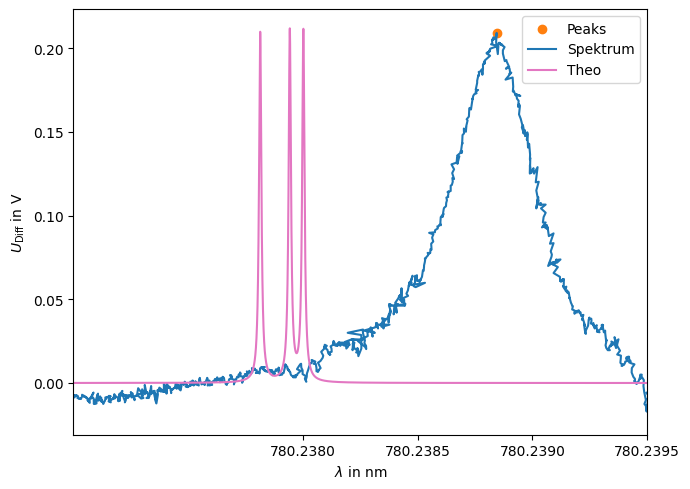

In [153]:
spek3=Spek(6,cut=True)
spek3.a,spek3.b=6800,7700
# spek3.plot()
spek3.peaks()
spek3.spek_theo_func()
spek3.plot_diff()

In [17]:
peak_lit=780+np.array([.238,.244,.246,.247])
print(peak_lit)
abs_err=(peak_lit-spek3.peaks)
rel_err=(peak_lit-spek3.peaks)/peak_lit
abs_dist=(spek3.peaks[3]-spek3.peaks[0])-(peak_lit[3]-peak_lit[0])
rel_dist=((spek3.peaks[3]-spek3.peaks[0])-(peak_lit[3]-peak_lit[0]))/(peak_lit[3]-peak_lit[0])
print(abs_dist,rel_dist)

[780.238 780.244 780.246 780.247]
-0.0012680831720217611 -0.14089813022619213


In [18]:
peak_heigths_85=spek3.diff[spek3.peaks_i][0]+spek3.diff[spek3.peaks_i][1]
peak_heigths_87=spek3.diff[spek3.peaks_i][3]*2
quot=peak_heigths_87/peak_heigths_85
print(quot)
print(27.835/72.168)

0.5424293964529241
0.38569726194435205
